In [1]:
!pip install census
!pip install us
!pip install sodapy

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
from sodapy import Socrata
from shapely.geometry import Point
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import KernelDensity
from shapely.geometry import box
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import seaborn as sns


In [2]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
# client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org",
                  "PXGs3LAGSv2IZaGVJVPf1M0Fz",
                  username="jijinc@upenn.edu",
                  password="8m9reD@XfA$Z5W.")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("dwme-t96c", limit=210000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [3]:
results_df

,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,...,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2021-12-31T23:59:00.000,"{'latitude': '41.894327846', 'human_address': ...",018,006XX N STATE ST,1904872,41.894327846,LIQUOR LICENSE VIOLATION,HOTEL / MOTEL,2022-01-08T15:39:35.000,8,...,42,JF103542,2021,False,22,-87.62814321,1832,LIQUOR LAW VIOLATION,True,12584710
1,2021-12-31T23:59:00.000,NaN,008,023XX W 64TH ST,NaN,NaN,OVER $500,SCHOOL - PUBLIC BUILDING,2022-02-05T15:40:37.000,66,...,16,JF133671,2021,False,06,NaN,0825,THEFT,False,12609426
2,2021-12-31T23:58:00.000,"{'latitude': '41.745680051', 'human_address': ...",004,082XX S MARQUETTE AVE,1850868,41.745680051,HOME INVASION,APARTMENT,2022-01-07T15:44:31.000,46,...,7,JF100042,2021,True,05,-87.558851198,0423,BURGLARY,False,12581979
3,2021-12-31T23:55:00.000,"{'latitude': '41.734916889', 'human_address': ...",022,087XX S WOOD ST,1846697,41.734916889,TO PROPERTY,RESIDENCE,2022-01-07T15:44:31.000,71,...,21,JF102969,2021,False,14,-87.66790905,2221,CRIMINAL DAMAGE,False,12584234
4,2021-12-31T23:50:00.000,"{'latitude': '41.770713582', 'human_address': ...",003,068XX S CHAMPLAIN AVE,1859870,41.770713582,TO RESIDENCE,APARTMENT,2022-01-07T15:44:31.000,42,...,20,JF100045,2021,False,26,-87.609358643,0321,CRIMINAL TRESPASS,False,12581975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209397,2021-01-01T00:00:00.000,"{'latitude': '41.725762292', 'human_address': ...",004,093XX S BENNETT AVE,1843564,41.725762292,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,RESIDENCE,2021-04-14T15:41:04.000,48,...,8,JE197150,2021,True,02,-87.57787575,0413,OFFENSE INVOLVING CHILDREN,False,12338506
209398,2021-01-01T00:00:00.000,"{'latitude': '41.958971937', 'human_address': ...",019,042XX N BROADWAY,1928373,41.958971937,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,2021-11-13T15:39:51.000,3,...,46,JE441404,2021,False,11,-87.653365753,1915,DECEPTIVE PRACTICE,False,12537851
209399,2021-01-01T00:00:00.000,"{'latitude': '42.019380398', 'human_address': ...",024,016XX W HOWARD ST,1950346,42.019380398,FINANCIAL IDENTITY THEFT $300 AND UNDER,APARTMENT,2021-05-04T15:40:05.000,1,...,49,JE216275,2021,True,11,-87.672249127,2422,DECEPTIVE PRACTICE,False,12354069
209400,2021-01-01T00:00:00.000,"{'latitude': '41.778229684', 'human_address': ...",008,063XX S ROCKWELL ST,1862437,41.778229684,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,2023-02-21T15:43:50.000,66,...,16,JE447436,2021,True,17,-87.688505893,0825,OFFENSE INVOLVING CHILDREN,False,12545674


In [4]:
assault = results_df[results_df["primary_type"] == "ASSAULT"].copy()

assault['geometry'] = assault.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

Assault21 = gpd.GeoDataFrame(assault, geometry='geometry')

Assault21.crs = "EPSG:4326"

Assault21

,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,...,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id,geometry
5,2021-12-31T23:50:00.000,"{'latitude': '41.800089835', 'human_address': ...",008,051XX S SPAULDING AVE,1870367,41.800089835,SIMPLE,APARTMENT,2022-01-07T15:44:31.000,63,...,JF100292,2021,False,08A,-87.706195287,0822,ASSAULT,False,12582027,POINT (-87.70620 41.80009)
7,2021-12-31T23:46:00.000,"{'latitude': '41.745827204', 'human_address': ...",006,009XX E 82ND ST,1850818,41.745827204,AGGRAVATED - HANDGUN,APARTMENT,2022-01-07T15:44:31.000,44,...,JF100025,2021,True,04A,-87.602254489,0631,ASSAULT,False,12581871,POINT (-87.60225 41.74583)
23,2021-12-31T23:06:00.000,"{'latitude': '41.89668614', 'human_address': '...",018,0000X E CHICAGO AVE,1905733,41.89668614,SIMPLE,RESTAURANT,2022-01-07T15:44:31.000,8,...,JE494453,2021,False,08A,-87.627412043,1833,ASSAULT,True,12581778,POINT (-87.62741 41.89669)
58,2021-12-31T22:05:00.000,"{'latitude': '41.785957604', 'human_address': ...",008,039XX W 59TH ST,1865187,41.785957604,AGGRAVATED - HANDGUN,APARTMENT,2022-01-07T15:44:31.000,65,...,JE494409,2021,True,04A,-87.721623241,0822,ASSAULT,False,12582370,POINT (-87.72162 41.78596)
65,2021-12-31T22:00:00.000,"{'latitude': '41.801535279', 'human_address': ...",009,009XX W 51ST ST,1871013,41.801535279,SIMPLE,APARTMENT,2022-01-07T15:44:31.000,61,...,JF100618,2021,True,08A,-87.64885291,0934,ASSAULT,False,12582361,POINT (-87.64885 41.80154)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209118,2021-01-01T01:32:00.000,"{'latitude': '41.868043561', 'human_address': ...",011,038XX W FILLMORE ST,1895100,41.868043561,SIMPLE,APARTMENT,2021-11-17T15:40:16.000,29,...,JE100548,2021,True,08A,-87.720966147,1133,ASSAULT,False,12258986,POINT (-87.72097 41.86804)
209129,2021-01-01T01:22:00.000,"{'latitude': '41.781326622', 'human_address': ...",007,009XX W 63RD PKWY,1863652,41.781326622,SIMPLE,APARTMENT,2021-01-16T15:39:23.000,68,...,JE100098,2021,False,08A,-87.647516964,0712,ASSAULT,False,12258648,POINT (-87.64752 41.78133)
209138,2021-01-01T01:00:00.000,"{'latitude': '41.77999793', 'human_address': '...",003,001XX W 63RD ST,1863208,41.77999793,SIMPLE,GAS STATION,2021-01-16T15:39:23.000,68,...,JE100026,2021,False,08A,-87.629294594,0311,ASSAULT,False,12259387,POINT (-87.62929 41.78000)
209323,2021-01-01T00:00:00.000,"{'latitude': '41.910909931', 'human_address': ...",025,016XX N CICERO AVE,1910673,41.910909931,AGGRAVATED - HANDGUN,ALLEY,2021-01-16T15:39:23.000,25,...,JE100369,2021,False,04A,-87.745898897,2533,ASSAULT,False,12258861,POINT (-87.74590 41.91091)


In [5]:
c = Census("0e028dfcee38f844e89c39d01870f6a964f675a2")

In [6]:
chicensus = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.IL.fips,
                                      county_fips = "031",
                                      tract = "*",
                                      year = 2021)

chidf = pd.DataFrame(chicensus)

In [7]:
chidf

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract
0,"Census Tract 101, Cook County, Illinois",4439.0,495.0,692.0,4534.0,17,031,010100
1,"Census Tract 102.01, Cook County, Illinois",8219.0,1628.0,1271.0,8232.0,17,031,010201
2,"Census Tract 102.02, Cook County, Illinois",2813.0,116.0,396.0,3124.0,17,031,010202
3,"Census Tract 103, Cook County, Illinois",5189.0,251.0,362.0,6085.0,17,031,010300
4,"Census Tract 104, Cook County, Illinois",3011.0,385.0,330.0,4587.0,17,031,010400
...,...,...,...,...,...,...,...,...
1327,"Census Tract 8446, Cook County, Illinois",2307.0,151.0,191.0,2490.0,17,031,844600
1328,"Census Tract 8447, Cook County, Illinois",1573.0,173.0,202.0,1573.0,17,031,844700
1329,"Census Tract 9800, Cook County, Illinois",0.0,0.0,0.0,0.0,17,031,980000
1330,"Census Tract 9801, Cook County, Illinois",0.0,0.0,0.0,0.0,17,031,980100


In [8]:
chicagoBoundary = gpd.read_file("data/chicagoBoundary.geojson").to_crs(3435)

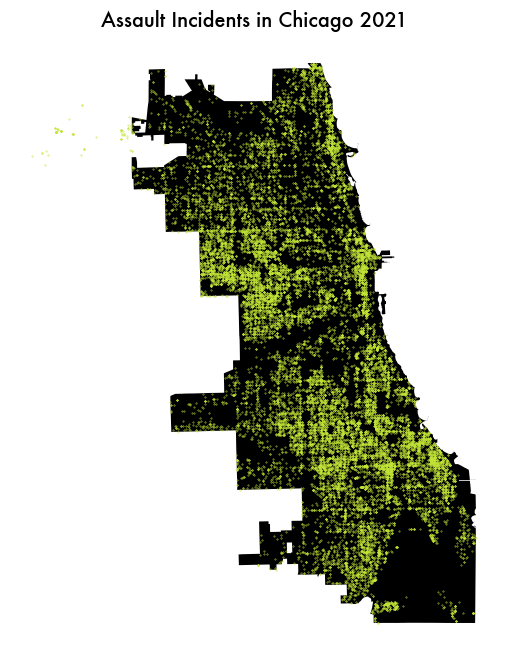

In [68]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Futura'
mpl.rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize=(12, 8))

# chicagoBoundary.plot(ax=ax, color='beige')
chicagoBoundary.to_crs(4326).plot(ax=ax, color='black')
# Assault21.to_crs()
Assault21.plot(ax=ax, color='#c2e538', markersize=0.1, label='Assault Incidents')

plt.title("Assault Incidents in Chicago 2021")
plt.xticks([])
plt.yticks([])
plt.gca().set_frame_on(False)

plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.gca().spines['left'].set_linewidth(0.8)
plt.gca().spines['bottom'].set_linewidth(0.8)

plt.show()

In [10]:
coords = np.array(list(zip(Assault21.geometry.x, Assault21.geometry.y)))
coords = coords[~np.isnan(coords).any(axis=1)]

In [11]:
def create_fishnet(boundary, cellsize):
    bounds = boundary.total_bounds  # Get bounding box of the area
    xmin, ymin, xmax, ymax = bounds
    cols = np.arange(xmin, xmax + cellsize, cellsize)
    rows = np.arange(ymin, ymax + cellsize, cellsize)
    polygons = [
        box(x, y, x + cellsize, y + cellsize)
        for x in cols[:-1] for y in rows[:-1]
    ]
    fishnet = gpd.GeoDataFrame(geometry=polygons, crs=boundary.crs)
    # Intersect with boundary
    fishnet = fishnet[fishnet.intersects(boundary.unary_union)]
    fishnet["uniqueID"] = range(1, len(fishnet) + 1)
    return fishnet

/Users/emmawit/miniforge3/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


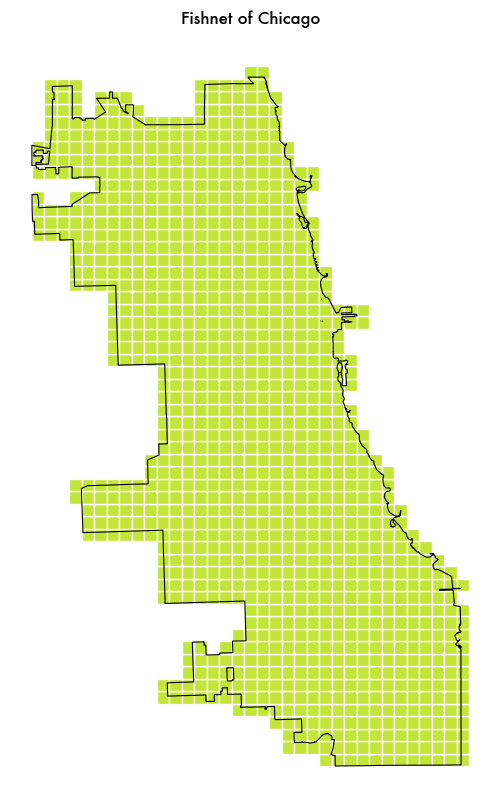

In [70]:
# Generate fishnet
fishnet = create_fishnet(chicagoBoundary, cellsize=2500)

# Plot fishnet
fig, ax = plt.subplots(figsize=(10, 10))
fishnet.plot(ax=ax, edgecolor="white", facecolor="#c2e538")
chicagoBoundary.boundary.plot(ax=ax, color="black", linewidth=0.8)
ax.set_title("Fishnet of Chicago", fontsize=12, fontweight="bold")
ax.axis("off")
plt.show()

In [13]:
# Count of Assaults in each fishnet grid
Assault21["countAssault"] = 1
Assault21_net = gpd.sjoin(fishnet, Assault21.to_crs(3435), how="left", op="contains")
Assault21_net = Assault21_net.groupby("uniqueID").agg(
    countAssault=("countAssault", "sum"),
    geometry=("geometry", "first")
).reset_index()

Assault21

/Users/emmawit/miniforge3/envs/musa-550-fall-2023/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,...,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id,geometry,countAssault
5,2021-12-31T23:50:00.000,"{'latitude': '41.800089835', 'human_address': ...",008,051XX S SPAULDING AVE,1870367,41.800089835,SIMPLE,APARTMENT,2022-01-07T15:44:31.000,63,...,2021,False,08A,-87.706195287,0822,ASSAULT,False,12582027,POINT (-87.70620 41.80009),1
7,2021-12-31T23:46:00.000,"{'latitude': '41.745827204', 'human_address': ...",006,009XX E 82ND ST,1850818,41.745827204,AGGRAVATED - HANDGUN,APARTMENT,2022-01-07T15:44:31.000,44,...,2021,True,04A,-87.602254489,0631,ASSAULT,False,12581871,POINT (-87.60225 41.74583),1
23,2021-12-31T23:06:00.000,"{'latitude': '41.89668614', 'human_address': '...",018,0000X E CHICAGO AVE,1905733,41.89668614,SIMPLE,RESTAURANT,2022-01-07T15:44:31.000,8,...,2021,False,08A,-87.627412043,1833,ASSAULT,True,12581778,POINT (-87.62741 41.89669),1
58,2021-12-31T22:05:00.000,"{'latitude': '41.785957604', 'human_address': ...",008,039XX W 59TH ST,1865187,41.785957604,AGGRAVATED - HANDGUN,APARTMENT,2022-01-07T15:44:31.000,65,...,2021,True,04A,-87.721623241,0822,ASSAULT,False,12582370,POINT (-87.72162 41.78596),1
65,2021-12-31T22:00:00.000,"{'latitude': '41.801535279', 'human_address': ...",009,009XX W 51ST ST,1871013,41.801535279,SIMPLE,APARTMENT,2022-01-07T15:44:31.000,61,...,2021,True,08A,-87.64885291,0934,ASSAULT,False,12582361,POINT (-87.64885 41.80154),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209118,2021-01-01T01:32:00.000,"{'latitude': '41.868043561', 'human_address': ...",011,038XX W FILLMORE ST,1895100,41.868043561,SIMPLE,APARTMENT,2021-11-17T15:40:16.000,29,...,2021,True,08A,-87.720966147,1133,ASSAULT,False,12258986,POINT (-87.72097 41.86804),1
209129,2021-01-01T01:22:00.000,"{'latitude': '41.781326622', 'human_address': ...",007,009XX W 63RD PKWY,1863652,41.781326622,SIMPLE,APARTMENT,2021-01-16T15:39:23.000,68,...,2021,False,08A,-87.647516964,0712,ASSAULT,False,12258648,POINT (-87.64752 41.78133),1
209138,2021-01-01T01:00:00.000,"{'latitude': '41.77999793', 'human_address': '...",003,001XX W 63RD ST,1863208,41.77999793,SIMPLE,GAS STATION,2021-01-16T15:39:23.000,68,...,2021,False,08A,-87.629294594,0311,ASSAULT,False,12259387,POINT (-87.62929 41.78000),1
209323,2021-01-01T00:00:00.000,"{'latitude': '41.910909931', 'human_address': ...",025,016XX N CICERO AVE,1910673,41.910909931,AGGRAVATED - HANDGUN,ALLEY,2021-01-16T15:39:23.000,25,...,2021,False,04A,-87.745898897,2533,ASSAULT,False,12258861,POINT (-87.74590 41.91091),1


In [14]:
Assault21.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
Assault21_net["countAssault"] = Assault21_net["countAssault"].fillna(0)

# Add uniqueID and cross-validation IDs
Assault21_net["uniqueID"] = range(1, len(Assault21_net) + 1)
Assault21_net["cvID"] = np.random.randint(
    low=1, high=(len(Assault21_net) // 24) + 1, size=len(Assault21_net)
)

Assault21_net

,uniqueID,countAssault,geometry,cvID
0,1,1.0,"POLYGON ((1121801.540 1918892.156, 1121801.540...",44
1,2,8.0,"POLYGON ((1121801.540 1921392.156, 1121801.540...",16
2,3,7.0,"POLYGON ((1121801.540 1923892.156, 1121801.540...",35
3,4,0.0,"POLYGON ((1121801.540 1926392.156, 1121801.540...",36
4,5,0.0,"POLYGON ((1121801.540 1931392.156, 1121801.540...",28
...,...,...,...,...
1093,1094,0.0,"POLYGON ((1206801.540 1836392.156, 1206801.540...",10
1094,1095,0.0,"POLYGON ((1206801.540 1838892.156, 1206801.540...",10
1095,1096,0.0,"POLYGON ((1206801.540 1841392.156, 1206801.540...",5
1096,1097,0.0,"POLYGON ((1206801.540 1843892.156, 1206801.540...",20


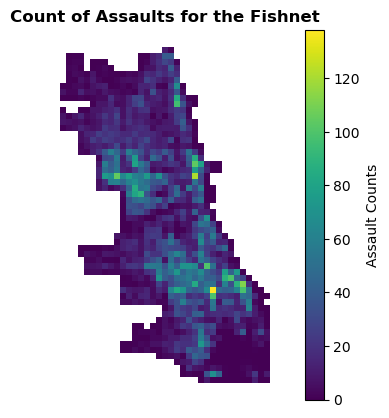

In [16]:
# Plot Assault Counts
fig, ax = plt.subplots()
Assault21_net = gpd.GeoDataFrame(Assault21_net, geometry='geometry')  # Ensure 'geometry' column exists
Assault21_net.plot(column='countAssault', ax=ax, legend=True, cmap='viridis', legend_kwds={'label': "Assault Counts"})

plt.title("Count of Assaults for the Fishnet", fontsize=12, fontweight='bold')
plt.axis('off')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

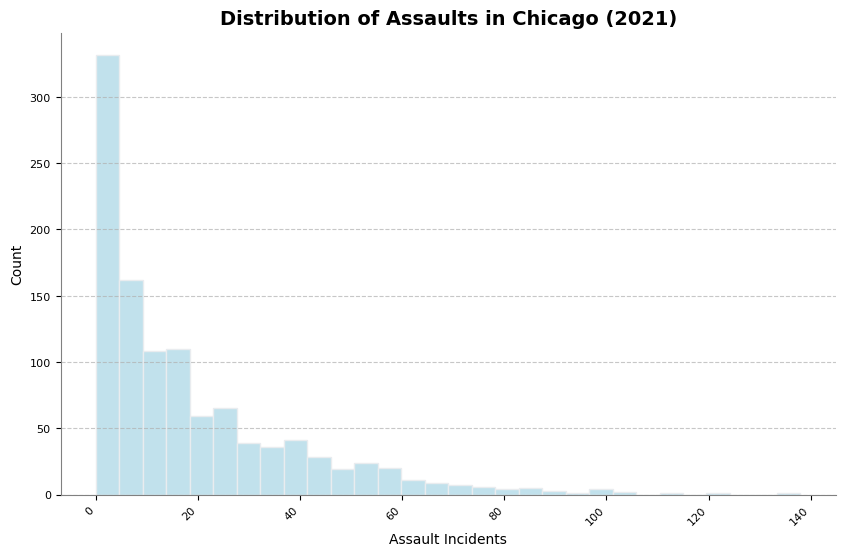

In [17]:
if Assault21_net['countAssault'].isna().any():
    Assault21_net = Assault21_net.dropna()

plt.figure(figsize=(10, 6))
sns.histplot(Assault21_net['countAssault'], bins=30, color="lightblue", edgecolor="#e9ecef")
plt.title("Distribution of Assaults in Chicago (2021)", fontsize=14, fontweight='bold')
plt.xlabel("Assault Incidents", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')
plt.show()

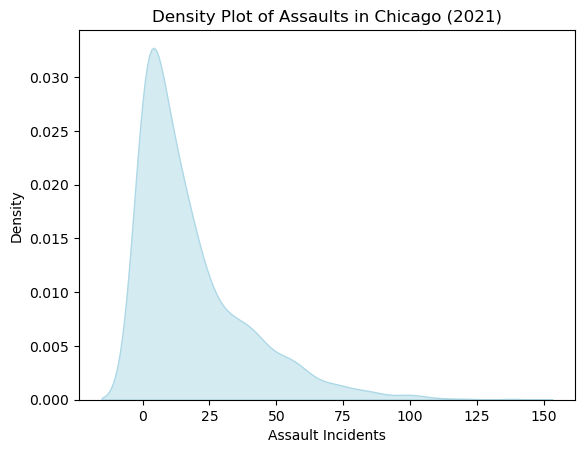

In [18]:
sns.kdeplot(data=Assault21_net, x='countAssault', fill=True, color='lightblue', alpha=0.5)
plt.title("Density Plot of Assaults in Chicago (2021)")
plt.xlabel("Assault Incidents")
plt.ylabel("Density")
plt.show()

In [27]:
graffiti = client.get("hec5-y4x5", limit=1000000)

graffiti = pd.DataFrame.from_records(graffiti)

In [28]:
graffiti['year'] = graffiti['creation_date'].str[:4]
graffiti = graffiti[graffiti['year'] == "2018"]
graffiti = graffiti[graffiti['where_is_the_graffiti_located_'].isin(["Front", "Rear", "Side"])]
graffiti = graffiti[['latitude', 'longitude']].dropna()

graffiti = gpd.GeoDataFrame(
    graffiti, 
    geometry=gpd.points_from_xy(graffiti.longitude, graffiti.latitude),
    crs="EPSG:4326"
)

graffiti = graffiti.to_crs(fishnet.crs)
graffiti['Legend'] = "Graffiti"

In [29]:
streetLightsOut = client.get("zuxi-7xem", limit=1000000)

streetLightsOut = pd.DataFrame.from_records(streetLightsOut)

In [30]:
streetLightsOut['year'] = streetLightsOut['creation_date'].str[:4]
streetLightsOut = streetLightsOut[streetLightsOut['year'] == "2018"]
streetLightsOut = streetLightsOut[['latitude', 'longitude']].dropna()
streetLightsOut = gpd.GeoDataFrame(streetLightsOut, geometry=gpd.points_from_xy(streetLightsOut.longitude, streetLightsOut.latitude), crs="EPSG:4326")
streetLightsOut = streetLightsOut.to_crs(fishnet.crs)
streetLightsOut['Legend'] = "streetLightsOut"

In [31]:
liquorRetail = client.get("nrmj-3kcf", limit=1000000)

liquorRetail = pd.DataFrame.from_records(liquorRetail)

In [32]:
liquorRetail = liquorRetail[liquorRetail['business_activity'] == "Retail Sales of Packaged Liquor"]
liquorRetail = liquorRetail[['latitude', 'longitude']].dropna()
liquorRetail = gpd.GeoDataFrame(liquorRetail, geometry=gpd.points_from_xy(liquorRetail.longitude, liquorRetail.latitude), crs="EPSG:4326")
liquorRetail = liquorRetail.to_crs(fishnet.crs)
liquorRetail['Legend'] = "liquorRetail"

In [33]:
shotSpotter = client.get("3h7q-7mdb", limit=1000000)

shotSpotter = pd.DataFrame.from_records(shotSpotter)

In [34]:
shotSpotter = shotSpotter[['latitude', 'longitude']].dropna()
shotSpotter = gpd.GeoDataFrame(shotSpotter, geometry=gpd.points_from_xy(shotSpotter.longitude, shotSpotter.latitude), crs="EPSG:4326")
shotSpotter = shotSpotter.to_crs(fishnet.crs)
shotSpotter['Legend'] = "shotSpotter"

In [35]:
variable_net = pd.concat([streetLightsOut, liquorRetail, graffiti, shotSpotter]) \
                .sjoin(fishnet, how="inner", predicate='within') #\

In [36]:
variable_net = gpd.GeoDataFrame(variable_net, geometry='geometry', crs="EPSG:4326")

In [37]:
variable_net

,latitude,longitude,geometry,Legend,index_right,uniqueID
0,41.66329091907985,-87.63781345972885,POINT (1174294.60116 1820662.65208),streetLightsOut,1178,714
78,41.66252879010104,-87.63779900008863,POINT (1174300.79464 1820384.97376),streetLightsOut,1178,714
1956,41.66324371090597,-87.64150879096508,POINT (1173285.00739 1820637.32755),streetLightsOut,1178,714
2003,41.66443411231659,-87.64146080782693,POINT (1173294.63443 1821071.19997),streetLightsOut,1178,714
2033,41.663283479526456,-87.63900742937679,POINT (1173968.37640 1820657.31208),streetLightsOut,1178,714
...,...,...,...,...,...,...
164967,41.797358504,-87.801782759,POINT (1129189.20309 1869196.50642),shotSpotter,190,31
203451,41.796964146,-87.802170246,POINT (1129084.43377 1869052.15201),shotSpotter,190,31
175163,41.658698869,-87.537112847,POINT (1201826.08226 1819227.36766),shotSpotter,1850,1071
187824,41.825602504,-87.737276159,POINT (1146707.10167 1879603.84141),shotSpotter,586,209


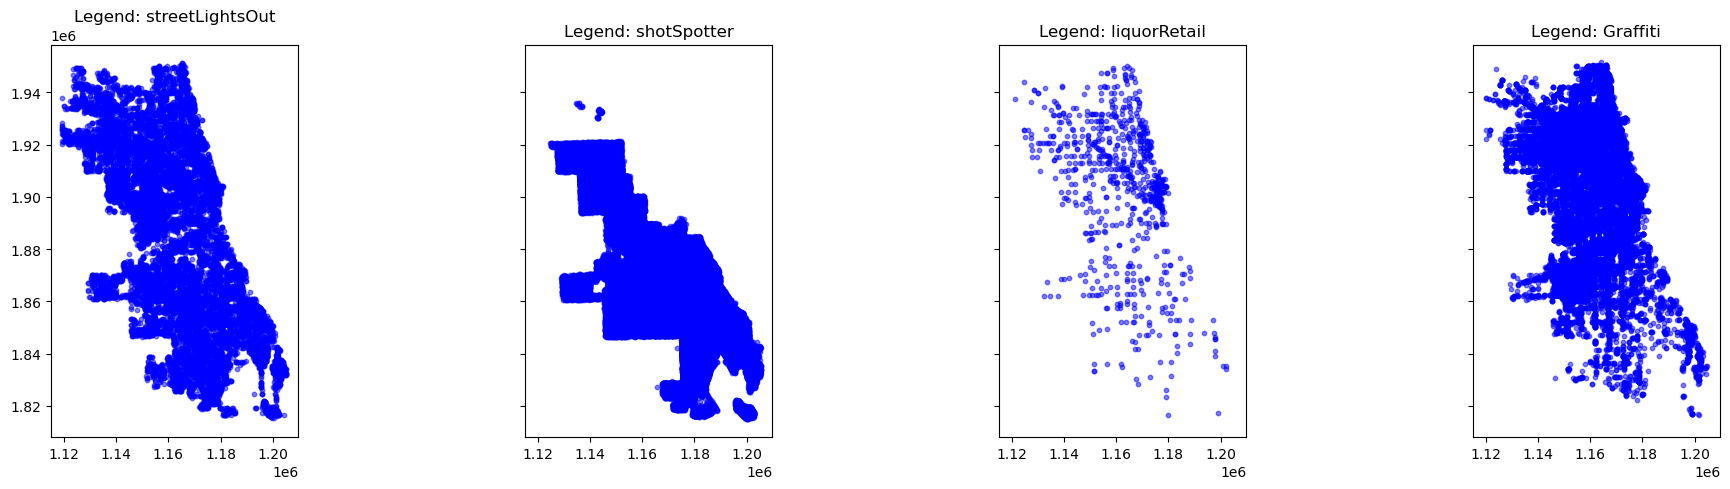

In [38]:
legend_values = variable_net['Legend'].unique()

# Create subplots
fig, axes = plt.subplots(1, len(legend_values), figsize=(20, 5), sharex=True, sharey=True)

for ax, legend_value in zip(axes, legend_values):
    subset = variable_net[variable_net['Legend'] == legend_value]
    subset.plot(ax=ax, marker='o', color='blue', markersize=10, alpha=0.5, aspect=1)
    ax.set_title(f"Legend: {legend_value}")
    ax.set_aspect('equal')  # Set aspect to 'equal' manually
    ax.axis('on')  # Keep axis visible for better debugging

plt.tight_layout()
plt.show()

In [41]:
!pip install esda

from libpysal.weights import Queen
from esda.moran import Moran_Local

  Obtaining dependency information for esda from https://files.pythonhosted.org/packages/a0/1b/84eaa84fa0e2b56464665f1d2135e0afe8ab1df481e6aa1fcdcb480032d6/esda-2.6.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.1 MB/s eta 0:00:0000:01


In [42]:
w = Queen.from_dataframe(Assault21_net, use_index = False)
y = Assault21_net['countAssault']
moran_loc = Moran_Local(y, w)

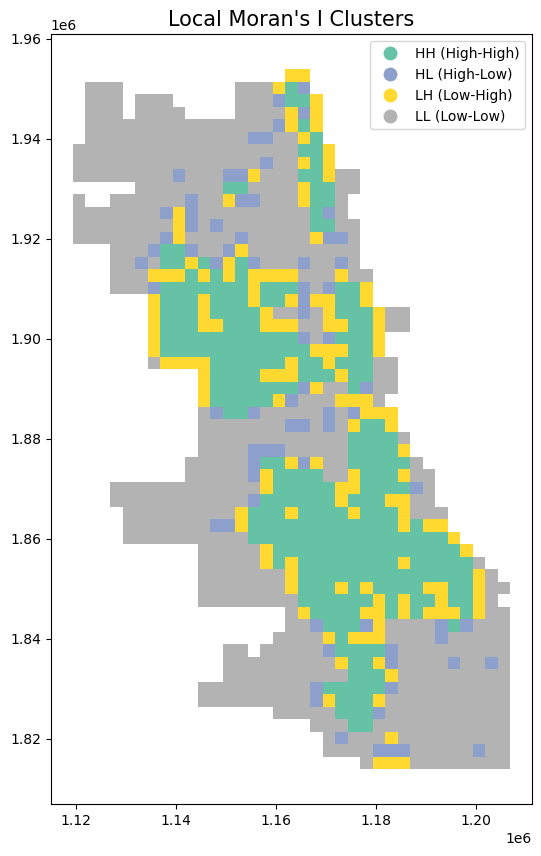

In [43]:
Assault21_net['LocalMoran'] = moran_loc.Is
Assault21_net['Cluster'] = moran_loc.q
cluster_labels = {
    1: "HH (High-High)",
    2: "LH (Low-High)",
    3: "LL (Low-Low)",
    4: "HL (High-Low)"
}
Assault21_net['ClusterLabel'] = Assault21_net['Cluster'].map(cluster_labels)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
Assault21_net.plot(column='ClusterLabel', categorical=True, legend=True, cmap='Set2', ax=ax)
plt.title("Local Moran's I Clusters", fontsize=15)
plt.show()

In [44]:
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

#variable_net = variable_net.to_crs(epsg=26971) 
#Assault21 = Assault21.to_crs(epsg=26971)

variable_net['x'] = variable_net.geometry.x
variable_net['y'] = variable_net.geometry.y
features = variable_net[['x', 'y']]

In [45]:
features

,x,y
0,1.174295e+06,1.820663e+06
78,1.174301e+06,1.820385e+06
1956,1.173285e+06,1.820637e+06
2003,1.173295e+06,1.821071e+06
2033,1.173968e+06,1.820657e+06
...,...,...
164967,1.129189e+06,1.869197e+06
203451,1.129084e+06,1.869052e+06
175163,1.201826e+06,1.819227e+06
187824,1.146707e+06,1.879604e+06


In [46]:
# Step 3: Determine the optimal number of clusters (Optional - Elbow Method)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

/Users/emmawit/miniforge3/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/emmawit/miniforge3/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/emmawit/miniforge3/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/emmawit/miniforge3/envs/musa-550-fall-2023/lib/python3.10/si

In [47]:
inertia

[319262043960158.0,
 109963861030452.19,
 69086800539043.56,
 54954279538518.55,
 44728408740544.78,
 37266295717974.32,
 30767713953826.164,
 27036476429277.887,
 23996827393807.016,
 21617617531842.484]

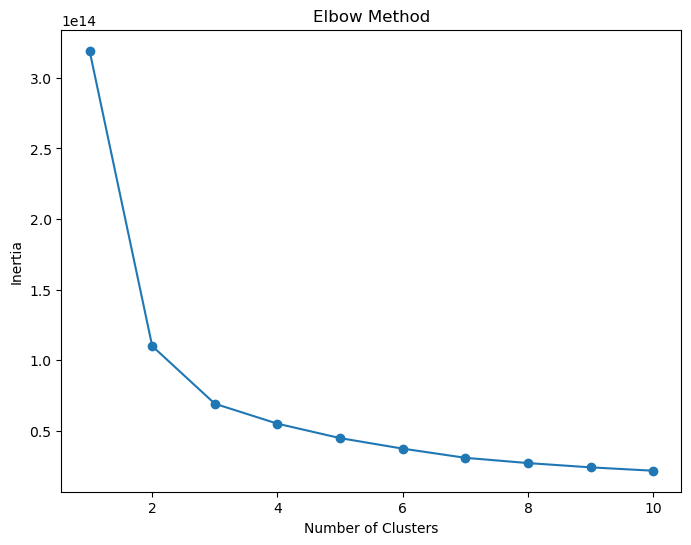

In [48]:
# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [49]:
# Step 4: Fit K-Means with the chosen number of clusters (e.g., k=4)
optimal_k = 3  # Replace with your chosen k based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
variable_net['cluster'] = kmeans.fit_predict(features)

/Users/emmawit/miniforge3/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [50]:
# Step 5: Calculate cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['x_centroid', 'y_centroid'])
centroids_gdf = gpd.GeoDataFrame(centroids, geometry=gpd.points_from_xy(centroids['x_centroid'], centroids['y_centroid']), crs=variable_net.crs)

In [51]:
Assault21 = Assault21[~Assault21.geometry.is_empty].copy()
centroids_gdf = centroids_gdf[~centroids_gdf.geometry.is_empty].copy()

# Step 2: Calculate distances using valid geometries
def calculate_nearest_cluster_projected(row, centroids):
    # Calculate Euclidean distances using projected CRS coordinates
    distances = centroids.apply(lambda c: ((row.geometry.x - c.geometry.x) ** 2 + (row.geometry.y - c.geometry.y) ** 2) ** 0.5, axis=1)
    return distances.idxmin(), distances.min()

nearest_cluster
0.0    20253
dtype: int64


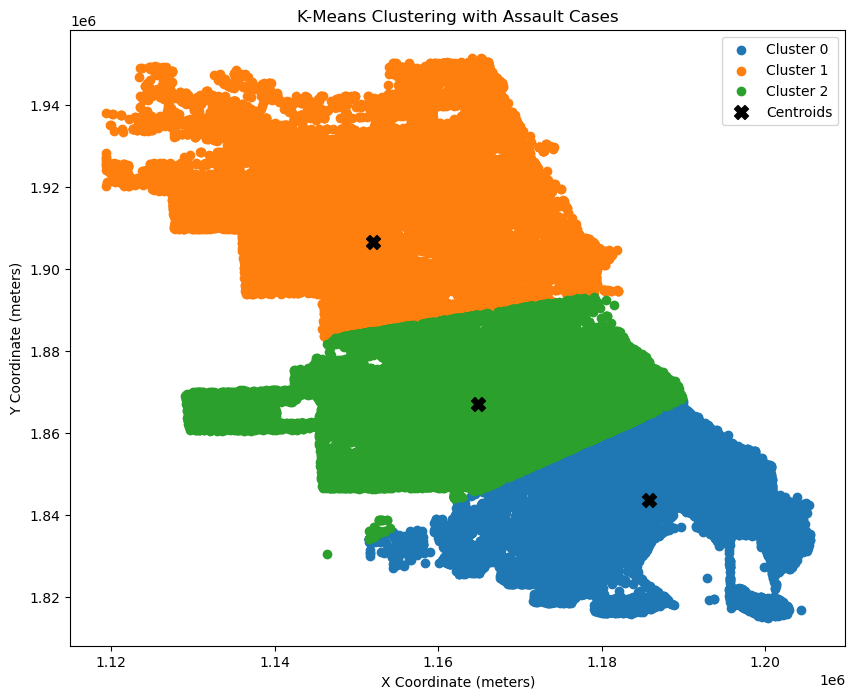

In [52]:
# Step 3: Apply the distance calculation
Assault21[['nearest_cluster', 'distance_to_cluster']] = Assault21.apply(
    lambda row: calculate_nearest_cluster_projected(row, centroids_gdf), axis=1, result_type='expand'
)

# Step 4: Analyze results
assaults_per_cluster = Assault21.groupby('nearest_cluster').size()
print(assaults_per_cluster)

# Visualization (unchanged)
plt.figure(figsize=(10, 8))
for cluster_id in range(optimal_k):
    cluster_points = variable_net[variable_net['cluster'] == cluster_id]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster_id}')

#plt.scatter(Assault21.geometry.x, Assault21.geometry.y, color='red', label='Assault Cases', alpha=0.2)
plt.scatter(centroids_gdf.geometry.x, centroids_gdf.geometry.y, color='black', label='Centroids', marker='X', s=100)

plt.xlabel('X Coordinate (meters)')
plt.ylabel('Y Coordinate (meters)')
plt.title('K-Means Clustering with Assault Cases')
plt.legend()
plt.show()

In [53]:
import statsmodels.api as sm

fishnet = fishnet.to_crs(epsg=3435)

In [55]:
variable_net_index = variable_net.drop(columns=['index_right'])
variable_net_poly = gpd.sjoin(fishnet, variable_net_index, how='left', predicate='intersects')

/var/folders/_6/7_dyppvx4kl54x9k8qfyyzz80000gn/T/ipykernel_24257/3200189343.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3435
Right CRS: EPSG:4326

  variable_net_poly = gpd.sjoin(fishnet, variable_net_index, how='left', predicate='intersects')


In [56]:
# Aggregate variables by fishnet polygons
# Summing or averaging predictors as appropriate
legend_counts = variable_net_poly.groupby(['uniqueID_left', 'Legend']).size().unstack(fill_value=0)

# Rename columns for clarity
legend_counts.columns = ['Graffiti_count', 'StreetLightsOut_count', 'LiquorRetail_count', 'ShotSpotter_count']

# Reset the index to merge with the fishnet
legend_counts = legend_counts.reset_index()

# Rename `uniqueID_left` to `uniqueID` for consistency
legend_counts.rename(columns={'uniqueID_left': 'uniqueID'}, inplace=True)

# Merge aggregated legend counts back into the fishnet
variable_net_agg = fishnet.merge(legend_counts, on='uniqueID', how='left')

# Fill NaNs with 0 (if there are any empty cells)
variable_net_agg = variable_net_agg.fillna(0)

In [57]:
# Step 2: Merge variable_net and Assault21_net using fishnet
combined_net = Assault21_net.merge(variable_net_agg, on='geometry', how='left')

# Fill missing values with 0 for variables with no data in some grids
combined_net = combined_net.fillna(0)

In [58]:
features = combined_net.drop(columns=['geometry', 'countAssault'])  # Drop target and geometry
features = features.select_dtypes(include=[np.number])  # Keep only numeric columns

# Ensure the target variable is numeric
combined_net['countAssault'] = pd.to_numeric(combined_net['countAssault'], errors='coerce')
combined_net['countAssault'] = combined_net['countAssault'].fillna(0)

# Fit the Poisson regression model
import statsmodels.api as sm
poisson_model = sm.GLM(combined_net['countAssault'], features, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print model summary
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           countAssault   No. Observations:                 1098
Model:                            GLM   Df Residuals:                     1090
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9154.5
Date:                Thu, 26 Dec 2024   Deviance:                       14158.
Time:                        15:47:55   Pearson chi2:                 1.91e+04
No. Iterations:                    17   Pseudo R-squ. (CS):             0.9996
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
uniqueID_x                0.00

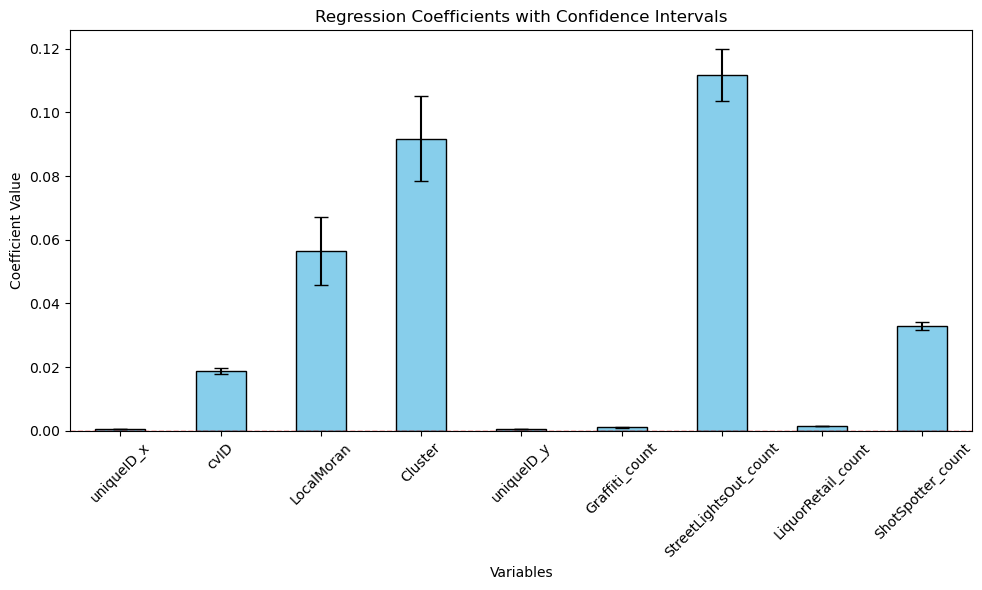

In [59]:
coefficients = poisson_results.params
conf_intervals = poisson_results.conf_int()
conf_intervals.columns = ['Lower 95%', 'Upper 95%']

# Combine coefficients and confidence intervals into a DataFrame
coef_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Lower CI': conf_intervals['Lower 95%'],
    'Upper CI': conf_intervals['Upper 95%']
})

# Plot
plt.figure(figsize=(10, 6))
coef_df['Coefficient'].plot(kind='bar', yerr=(coef_df['Coefficient'] - coef_df['Lower CI'], 
                                              coef_df['Upper CI'] - coef_df['Coefficient']),
                            capsize=5, color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Regression Coefficients with Confidence Intervals')
plt.ylabel('Coefficient Value')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

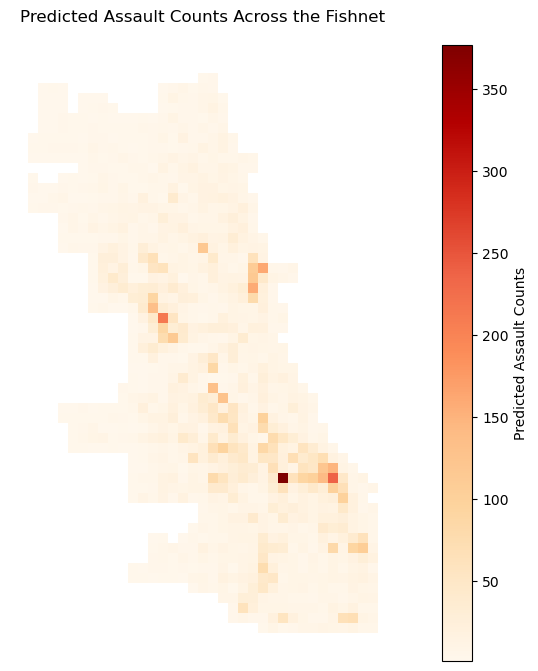

In [60]:
combined_net['predicted_assault_count'] = poisson_results.predict(features)

# Plot the predicted counts
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
combined_net.plot(column='predicted_assault_count', cmap='OrRd', legend=True, ax=ax,
                  legend_kwds={'label': "Predicted Assault Counts"})
plt.title("Predicted Assault Counts Across the Fishnet")
plt.axis('off')
plt.show()

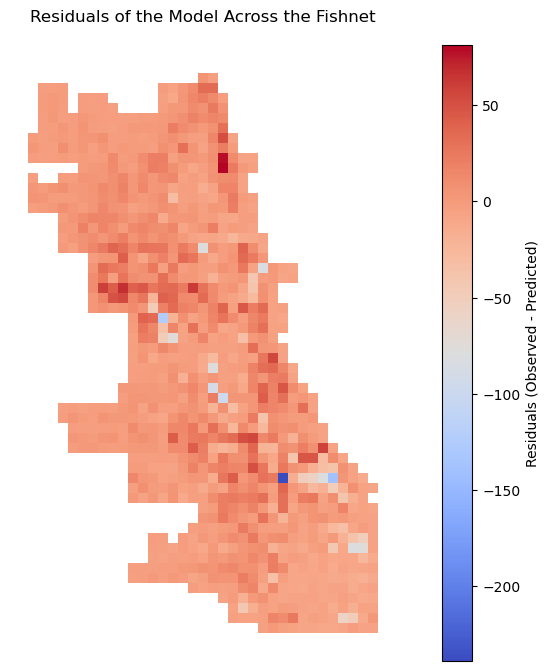

In [61]:
combined_net['residuals'] = combined_net['countAssault'] - combined_net['predicted_assault_count']

# Plot residuals
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
combined_net.plot(column='residuals', cmap='coolwarm', legend=True, ax=ax,
                  legend_kwds={'label': "Residuals (Observed - Predicted)"})
plt.title("Residuals of the Model Across the Fishnet")
plt.axis('off')
plt.show()

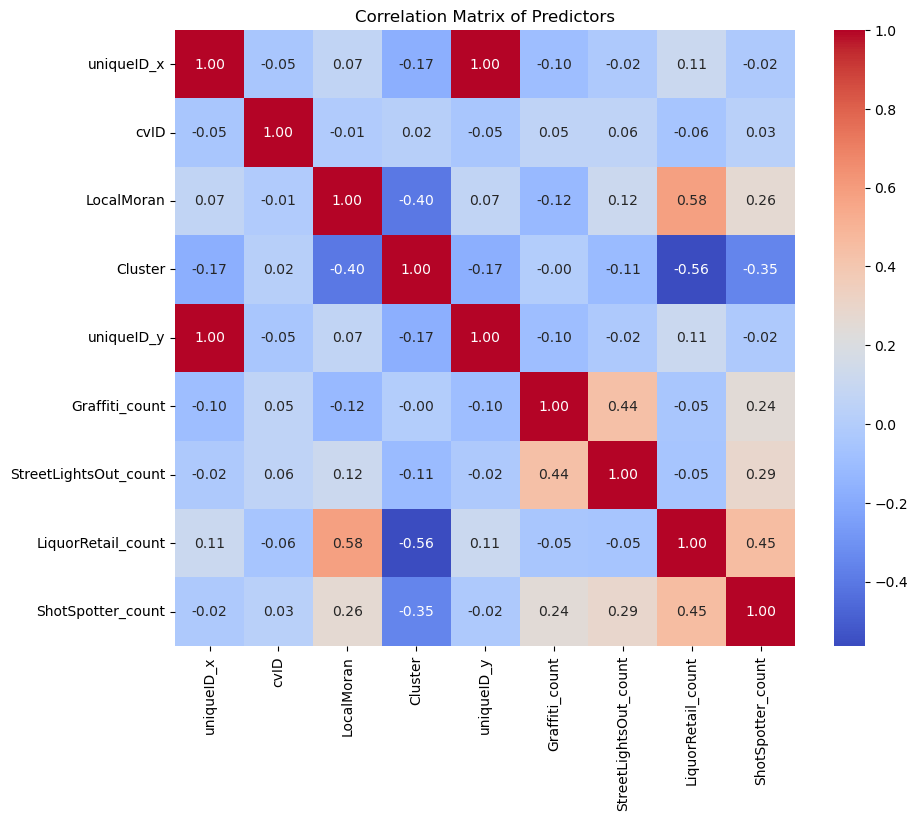

In [62]:
correlation_matrix = features.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Predictors')
plt.show()